# Two-step predict admissions using MSOA binned by IMD

Split the demographics data by IMD score to improve the correlation between the other variables.

Age proportions: proportion of patients in each age band.
Health proportions: proportion of patients with each of good, fair, and bad health.

There are two steps to predicting admission numbers in each IMD band:
+ Use the age-health fits to predict health proportions.
  + Each age band gives a separate set of health proportions from the age-health fits.
  + Combining the sets of health proportions with the known age proportions gives the health proportions across the whole MSOA.
+ Use the predicted health proportions with the health-admissions fits to predict admissions.

Both of these prediction steps use a linear regression.

## Code setup

In [1]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Patient demographics by MSOA:

In [2]:
path_to_msoa_stats = os.path.join('data', 'msoa_cleaned.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [3]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Check sum of admissions for Welsh areas:

In [4]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Welsh data is always zero so remove it.

In [5]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

Recalculate total numbers of patients:

In [6]:
df_stats = df_stats.with_columns((pl.col('good_health') + pl.col('fair health') + pl.col('bad health')).alias('total_health'))

In [7]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion,total_health
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64,i64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062,8524
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692,6634
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661,7100
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638,10127
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662,8526


Pick out column names for the health and age proportions:

In [8]:
health_numbers = ['good_health', 'fair health', 'bad health']
props_health = ['prop_good_health', 'prop_fair health', 'prop_bad health']
props_age = [
    'age_less65_proportion', 'age_65_proportion', 'age_70_proportion',
    'age_75_proportion', 'age_over80_proportion'
]

## Set up bins for IMD scores

Use quantiles so that each bin contains 10% of the MSOA (to match plot notebook).

The resulting dictionary has keys for which quantile it is and values for the left side (smaller, minimum value in bin) of the IMD bin.

In [9]:
dict_quantiles = {}

for q in np.arange(0.0, 1.01, 0.1):
    v = df_stats['IMD2019Score'].quantile(q)
    dict_quantiles[round(q, 1)] = round(v, 5)

In [10]:
dict_quantiles

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996,
 1.0: 87.02675}

Pick out just the values for the left edges of the bins:

In [11]:
imd_bin_left_edges = {}
for k in list(dict_quantiles.keys())[:-1]:
    imd_bin_left_edges[k] = dict_quantiles[k]

In [12]:
imd_bin_left_edges

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996}

Place MSOA into these bins:

In [13]:
# Make columns for the results with a placeholder value:
df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_min'))
df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_max'))

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    # Pick out the bin edges:
    q0 = dict_quantiles[quantile]
    q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
    # Find a mask for the demographic data that contains
    # only MSOA with IMD scores in this bin.
    mask = (df_stats['IMD2019Score'] >= q0) & (df_stats['IMD2019Score'] < q1)
    if q == len(dict_quantiles) - 2:
        # Also allow values at the right edge of the final bin.
        mask = mask | (df_stats['IMD2019Score'] == q1)

    # Update the bin min/max values for these rows:
    df_stats = df_stats.with_columns(
        pl.when((mask))
        .then(q0)         # replace with bin min
        .otherwise(pl.col('imd_bin_min'))  # otherwise keep the existing value
        .name.keep()
    )
    df_stats = df_stats.with_columns(
        pl.when((mask))
        .then(q1)         # replace with bin min
        .otherwise(pl.col('imd_bin_max'))  # otherwise keep the existing value
        .name.keep()
    )

Check that data was binned correctly:

In [14]:
df_stats[['IMD2019Score', 'imd_bin_min', 'imd_bin_max']]

IMD2019Score,imd_bin_min,imd_bin_max
f64,f64,f64
16.924833,15.2564,18.32929
6.4704,2.2122,7.708
13.7334,12.74375,15.2564
26.199857,21.81475,26.36117
11.7948,10.369,12.74375
…,…,…
3.25925,2.2122,7.708
7.29475,2.2122,7.708
12.117,10.369,12.74375


To check accuracy, the following function calculates R-squared:

In [22]:
def calculate_rsquared(y, yhat):
    """This gives the same results as the sklearn built-in."""
    y_mean = y.mean()
    ss_res = ((yhat - y)**2.0).sum()
    ss_tot = ((y - y_mean)**2.0).sum()
    if ss_tot != 0.0:
        rsq = 1.0 - ss_res / ss_tot
    else:
        rsq = np.NaN
    return rsq

## Admissions from health: calculate line equations

Loaded from the other notebook:

In [16]:
df_admissions_lines = pl.read_csv(os.path.join('outputs', 'line_fits_health_to_admissions.csv'))

In [17]:
df_admissions_lines

imd_bin_min,imd_bin_max,coeff_good_health,coeff_fair_health,coeff_bad_health,rsquared
f64,f64,f64,f64,f64,f64
2.2122,7.708,0.0,0.008549,0.017694,0.5722268
7.708,10.369,0.0,0.0101521,0.0091246,0.5156227
10.369,12.74375,0.0,0.0118571,0.0027425,0.5254204
12.74375,15.2564,0.0,0.0119053,0.0023227,0.565176
15.2564,18.32929,0.0,0.0121379,0.0,0.5270501
18.32929,21.81475,0.0,0.0116203,0.0000015,0.5140601
21.81475,26.36117,0.0,0.0110406,0.0006057,0.4988284
26.36117,31.84075,0.0,0.0093152,0.0031409,0.461555
31.84075,40.6996,0.0,0.0082107,0.0040624,0.4981876


### Check accuracy

Predict admissions from real data to see how good these coefficients are.

In [18]:
def calculate_admissions_from_health(df_stats, df_admissions_lines, col_n_good, col_n_fair, col_n_bad):
    # Make a copy of the MSOA data:
    cols_to_keep = ['MSOA', 'IMD2019Score', 'admissions'] + props_health + [col_n_good, col_n_fair, col_n_bad]
    df_p_admissions = df_stats[cols_to_keep]
    # Make column for the results with a placeholder value:
    col_admissions_pred = 'admissions_predicted'
    df_p_admissions = df_p_admissions.with_columns(pl.lit(0).alias(col_admissions_pred))
    
    for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
        # Pick out the bin edges:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        # Find a mask for the demographic data that contains
        # only MSOA with IMD scores in this bin.
        mask = (df_p_admissions['IMD2019Score'] >= q0) & (df_p_admissions['IMD2019Score'] < q1)
        if q == len(dict_quantiles) - 2:
            # Also allow values at the right edge of the final bin.
            mask = mask | (df_p_admissions['IMD2019Score'] == q1)
    
        # Pick out the line parameters for this IMD:
        mask_coeffs = ((df_admissions_lines['imd_bin_min'] == q0))
        coeff_good = df_admissions_lines.filter(mask_coeffs)['coeff_good_health'].to_numpy()[0]
        coeff_fair = df_admissions_lines.filter(mask_coeffs)['coeff_fair_health'].to_numpy()[0]
        coeff_bad = df_admissions_lines.filter(mask_coeffs)['coeff_bad_health'].to_numpy()[0]

        # Calculate new props:
        df_p_admissions = df_p_admissions.with_columns(
            pl.when((mask))
            .then(
                sum([
                    coeff_good * df_p_admissions[col_n_good],
                    coeff_fair * df_p_admissions[col_n_fair],
                    coeff_bad * df_p_admissions[col_n_bad]
                ]))  # replace with calculated values
            .otherwise(pl.col(col_admissions_pred))  # otherwise keep the existing value
            .name.keep()
        )
    return df_p_admissions[['MSOA', 'admissions', col_admissions_pred]]

In [19]:
df_admissions_pred_from_real = calculate_admissions_from_health(df_stats, df_admissions_lines, 'good_health', 'fair health', 'bad health')

Check results:

In [20]:
df_admissions_pred_from_real.head()

MSOA,admissions,admissions_predicted
str,f64,f64
"""Adur 001""",14.333333,15.184513
"""Adur 002""",7.333333,11.746808
"""Adur 003""",9.333333,12.258595
"""Adur 004""",21.0,17.498209
"""Adur 005""",13.666667,13.747233


Calculate r-squared of this fit:

In [23]:
rsq = calculate_rsquared(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_predicted']
)

rsq

0.5135151159801523

Plot predicted vs real admission numbers:

40.333333332


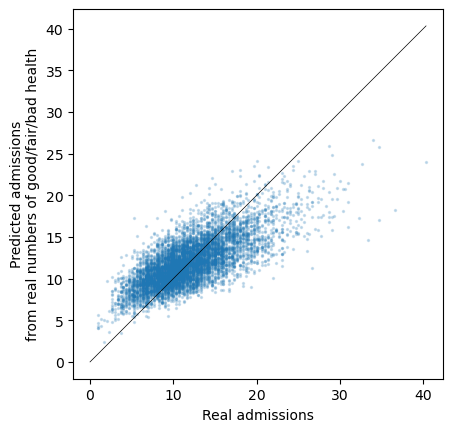

In [24]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions', 'admissions_predicted']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_predicted'],
    s=2, alpha=0.2
)

ax.set_xlabel('Real admissions')
ax.set_ylabel('Predicted admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

40.333333332


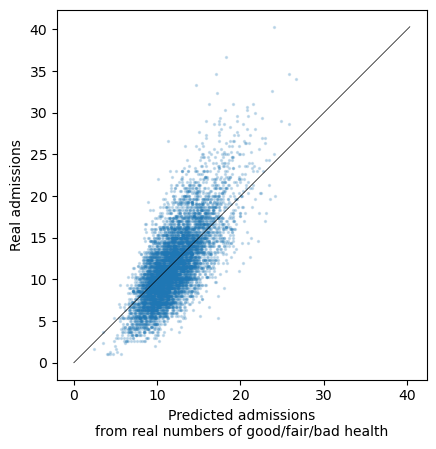

In [25]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions_predicted', 'admissions']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions_predicted'],
    df_admissions_pred_from_real['admissions'],
    s=2, alpha=0.2
)

ax.set_ylabel('Real admissions')
ax.set_xlabel('Predicted admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

### Fudge factor 1: simple version

Fit a straight line for real admissions from predicted:

In [26]:
# Fit a line to this selection:
y = (df_admissions_pred_from_real['admissions']).to_numpy()
X = df_admissions_pred_from_real['admissions_predicted'].to_numpy()
# Add the constant:
X = sm.add_constant(X)
# Fit line:
model = sm.OLS(y, X)
results = model.fit()
# Pick out coeffs, R^2:
coeffs = results.params
r2 = results.rsquared

In [27]:
m = coeffs[1]
c = coeffs[0]

coeffs

array([-1.77072816,  1.13939575])

In [28]:
r2

0.5217702362761149

Find where this line intersects with the $y=x$ line (all predicted admissions perfectly match real numbers):

In [29]:
# Lines y=x and y=mx+c intersect at this x:
xp = c / (1 - m)
# And this y:
yp = m*xp + c

Fudge the predicted admission numbers. Scale them so that predictions after the intersection point get scaled up and predictions before get scaled down.

In [30]:
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns(((pl.col('admissions_predicted') - yp)*m + yp).alias('admissions_fudged'))

In [31]:
df_admissions_pred_from_real.head()

MSOA,admissions,admissions_predicted,admissions_fudged
str,f64,f64,f64
"""Adur 001""",14.333333,15.184513,15.530441
"""Adur 002""",7.333333,11.746808,11.613535
"""Adur 003""",9.333333,12.258595,12.196663
"""Adur 004""",21.0,17.498209,18.166657
"""Adur 005""",13.666667,13.747233,13.89281


In [32]:
rsq = calculate_rsquared(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_fudged']
)

rsq

0.521770236276115

Plot resulting fudged admissions:

40.333333332


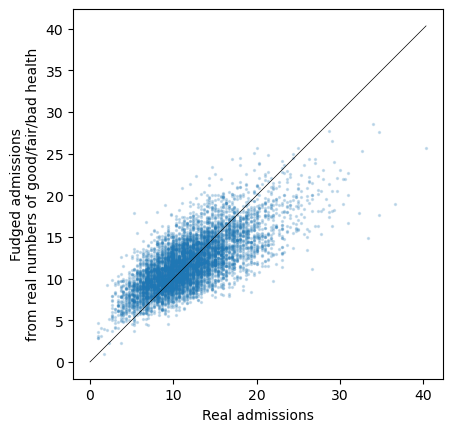

In [33]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions', 'admissions_fudged']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions'],
    df_admissions_pred_from_real['admissions_fudged'],
    s=2, alpha=0.2
)

ax.set_xlabel('Real admissions')
ax.set_ylabel('Fudged admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

40.333333332


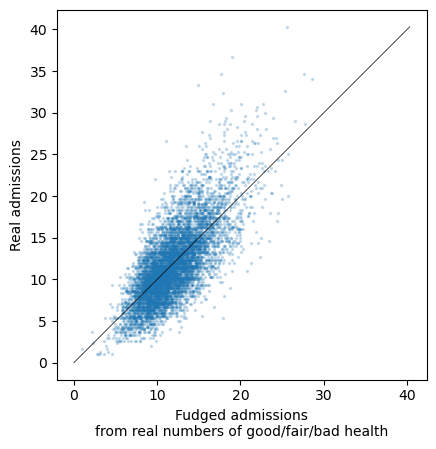

In [34]:
fig, ax = plt.subplots()

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions_fudged', 'admissions']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
ax.scatter(
    df_admissions_pred_from_real['admissions_fudged'],
    df_admissions_pred_from_real['admissions'],
    s=2, alpha=0.2
)

ax.set_ylabel('Real admissions')
ax.set_xlabel('Fudged admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

## Fudge factor 2: complicated version

Round the predicted admissions, then pick out each bin in turn and check the distribution of real admission numbers. Using the means and the standard deviations of those distributions, fudge the predicted admission values.

Round all predicted admissions to nearest integer:

In [35]:
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns((pl.col('admissions_predicted').round(0)).cast(int).alias('admissions_predicted_round'))

In [36]:
df_admissions_pred_from_real.head()

MSOA,admissions,admissions_predicted,admissions_fudged,admissions_predicted_round
str,f64,f64,f64,i64
"""Adur 001""",14.333333,15.184513,15.530441,15
"""Adur 002""",7.333333,11.746808,11.613535,12
"""Adur 003""",9.333333,12.258595,12.196663,12
"""Adur 004""",21.0,17.498209,18.166657,17
"""Adur 005""",13.666667,13.747233,13.89281,14


Make a violin plot of the distribution of real admission numbers at each bin of predicted admission numbers:

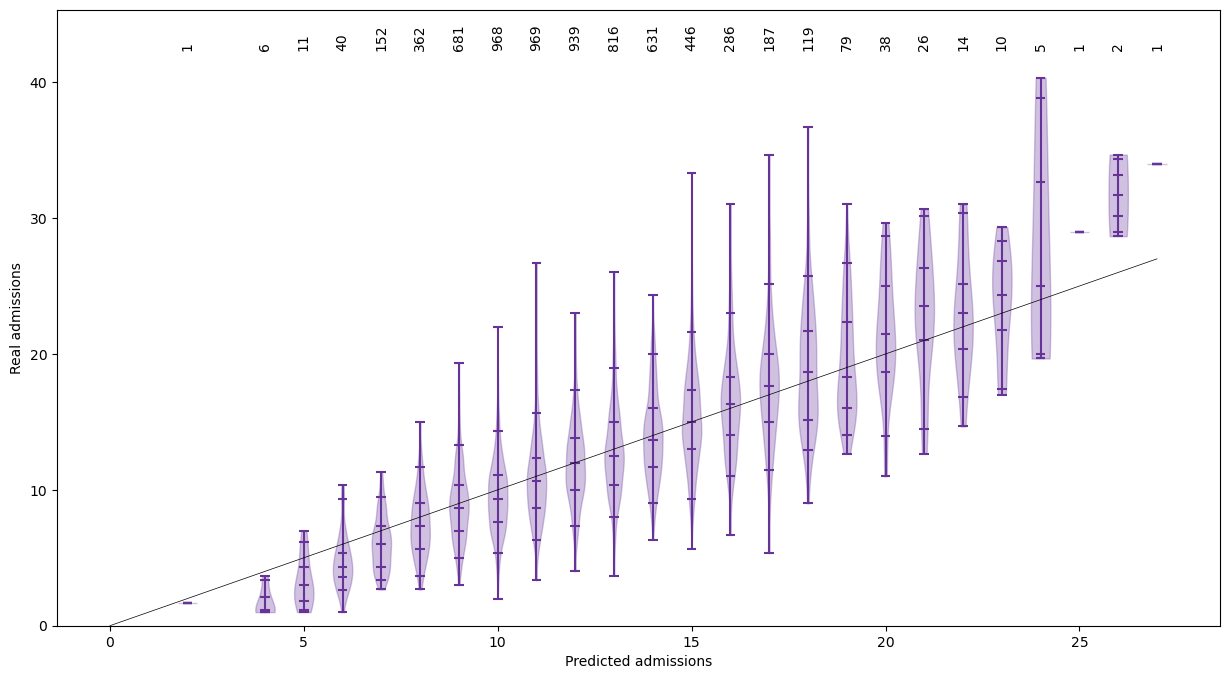

In [37]:
colour = 'RebeccaPurple'

ad_max = df_admissions_pred_from_real['admissions'].max()
ap_min = df_admissions_pred_from_real['admissions_predicted_round'].min()
ap_max = df_admissions_pred_from_real['admissions_predicted_round'].max()

fig, ax = plt.subplots(figsize=(15, 8))

for n_pred in range(ap_min, ap_max+1, 1):
    mask = df_admissions_pred_from_real['admissions_predicted_round'] == n_pred
    df_here = df_admissions_pred_from_real.filter(mask)

    if len(df_here) > 0:
        violin_bits = ax.violinplot(df_here['admissions'], positions=[n_pred], quantiles=[0.05, 0.25, 0.5, 0.75, 0.95])#showmeans=True)

        # Change colour:
        for pc in violin_bits['bodies']:
            pc.set_facecolor(colour)
            pc.set_edgecolor(colour)
        for partname in ('cbars','cmins','cmaxes', 'cquantiles'):  # , 'cmeans'):
            vp = violin_bits[partname]
            vp.set_edgecolor(colour)

        # Label number of MSOA that went into violin:
        ax.annotate(len(df_here), xy=(n_pred, ad_max+2), rotation=90, va='bottom', ha='center')

ax.set_ylim(0, ad_max+5)
# Equality line:
ax.plot([0, ap_max], [0, ap_max], color='k', linewidth=0.5)
ax.set_xlabel('Predicted admissions')
ax.set_ylabel('Real admissions')
plt.show()

Calculate stats for each violin - mean, std, confidence interval...

In [40]:
list_dicts_ci = []

z = 1.96  # 95% CI

for n_pred in range(ap_min, ap_max+1, 1):
    mask = df_admissions_pred_from_real['admissions_predicted_round'] == n_pred
    df_here = df_admissions_pred_from_real.filter(mask)
    p_n = len(df_here)

    # print(n_pred, len(df_here), df_here['admissions'].mean(), df_here['admissions'].median(), )
    if p_n > 0:
        # Calculate confidence interval
        p_mean = round(df_here['admissions'].mean(), 3)
        if p_n > 1:
            p_std = round(df_here['admissions'].std(), 3)
            ci_halfwidth = round(z * p_std / np.sqrt(p_n), 3)
            ci_top = p_mean + ci_halfwidth
            ci_bottom = p_mean - ci_halfwidth
        else:
            p_std = None
            ci_halfwidth = None
            ci_top = None
            ci_bottom = None
    else:
        p_mean = None
        p_std = None
        ci_halfwidth = None
        ci_top = None
        ci_bottom = None

    dict_ci = {}
    dict_ci['admissions_predicted'] = n_pred
    dict_ci['n_msoa'] = p_n
    dict_ci['mean'] = p_mean
    dict_ci['std'] = p_std
    try:
        dict_ci['mean_plus_1std'] = p_mean + p_std
        dict_ci['mean_minus_1std'] = p_mean - p_std
    except TypeError:
        dict_ci['mean_plus_1std'] = None
        dict_ci['mean_minus_1std'] = None
    dict_ci['halfwidth'] = ci_halfwidth
    dict_ci['ci95_top'] = ci_top
    dict_ci['ci95_bottom'] = ci_bottom

    list_dicts_ci.append(dict_ci)

# Convert list of dicts into dataframe:
df_pred_ci = pl.from_dicts(list_dicts_ci)

View the results:

In [41]:
with pl.Config(set_tbl_rows=50):  # force all rows to display
    print(df_pred_ci)

shape: (26, 9)
┌───────────────┬────────┬────────┬───────┬───┬───────────────┬───────────┬──────────┬─────────────┐
│ admissions_pr ┆ n_msoa ┆ mean   ┆ std   ┆ … ┆ mean_minus_1s ┆ halfwidth ┆ ci95_top ┆ ci95_bottom │
│ edicted       ┆ ---    ┆ ---    ┆ ---   ┆   ┆ td            ┆ ---       ┆ ---      ┆ ---         │
│ ---           ┆ i64    ┆ f64    ┆ f64   ┆   ┆ ---           ┆ f64       ┆ f64      ┆ f64         │
│ i64           ┆        ┆        ┆       ┆   ┆ f64           ┆           ┆          ┆             │
╞═══════════════╪════════╪════════╪═══════╪═══╪═══════════════╪═══════════╪══════════╪═════════════╡
│ 2             ┆ 1      ┆ 1.667  ┆ null  ┆ … ┆ null          ┆ null      ┆ null     ┆ null        │
│ 3             ┆ 0      ┆ null   ┆ null  ┆ … ┆ null          ┆ null      ┆ null     ┆ null        │
│ 4             ┆ 6      ┆ 1.722  ┆ 1.084 ┆ … ┆ 0.638         ┆ 0.867     ┆ 2.589    ┆ 0.855       │
│ 5             ┆ 11     ┆ 3.242  ┆ 1.898 ┆ … ┆ 1.344         ┆ 1.122     ┆ 

Fit lines to means and pm stds:

In [42]:
def calculate_line_fit(df, col_y, cols_X):
    # Fit a line to this selection:
    y = (df[col_y]).to_numpy()
    X = df[cols_X].to_numpy()
    # # Add the constant:
    X = sm.add_constant(X)
    # Fit line:
    model = sm.OLS(y, X)
    results = model.fit()
    return results

min_msoa = 20

mask = df_pred_ci['mean'].is_not_null() & (df_pred_ci['n_msoa'] >= min_msoa)
mean_results = calculate_line_fit(df_pred_ci.filter(mask), 'mean', ['admissions_predicted'])

mask = df_pred_ci['std'].is_not_null() & (df_pred_ci['n_msoa'] >= min_msoa)
mean_minus_1std_results = calculate_line_fit(df_pred_ci.filter(mask), 'mean_minus_1std', ['admissions_predicted'])
mean_plus_1std_results = calculate_line_fit(df_pred_ci.filter(mask), 'mean_plus_1std', ['admissions_predicted'])

# Pick out coeffs, R^2:
mean_coeffs = mean_results.params
mean_r2 = mean_results.rsquared
mean_m = mean_coeffs[1]
mean_c = mean_coeffs[0]
# mean_m = mean_coeffs[0]
# mean_c = 0.0

mean_minus_1std_coeffs = mean_minus_1std_results.params
mean_minus_1std_r2 = mean_minus_1std_results.rsquared
mean_minus_1std_m = mean_minus_1std_coeffs[1]
mean_minus_1std_c = mean_minus_1std_coeffs[0]
# mean_minus_1std_m = mean_minus_1std_coeffs[0]
# mean_minus_1std_c = 0.0

mean_plus_1std_coeffs = mean_plus_1std_results.params
mean_plus_1std_r2 = mean_plus_1std_results.rsquared
mean_plus_1std_m = mean_plus_1std_coeffs[1]
mean_plus_1std_c = mean_plus_1std_coeffs[0]
# mean_plus_1std_m = mean_plus_1std_coeffs[0]
# mean_plus_1std_c = 0.0

Resulting fudge factor equations:

In [43]:
str_fudge_mean = r'$a_{\mathrm{fudge,mean}} = ' + f'{mean_m:.3f}' + r'\cdot a_{\mathrm{pred}} ' + f'{mean_c:+.3f}'
str_fudge_meanp1std = r'$a_{\mathrm{fudge,mean+1std}} = ' + f'{mean_plus_1std_m:.3f}' + r'\cdot a_{\mathrm{pred}} ' + f'{mean_plus_1std_c:+.3f}'
str_fudge_meanm1std = r'$a_{\mathrm{fudge,mean-1std}} = ' + f'{mean_minus_1std_m:.3f}' + r'\cdot a_{\mathrm{pred}} ' + f'{mean_minus_1std_c:+.3f}'


from IPython.display import display, Math
display(Math(str_fudge_mean))
display(Math(str_fudge_meanp1std))
display(Math(str_fudge_meanm1std))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Plot the fudge lines over the violins:

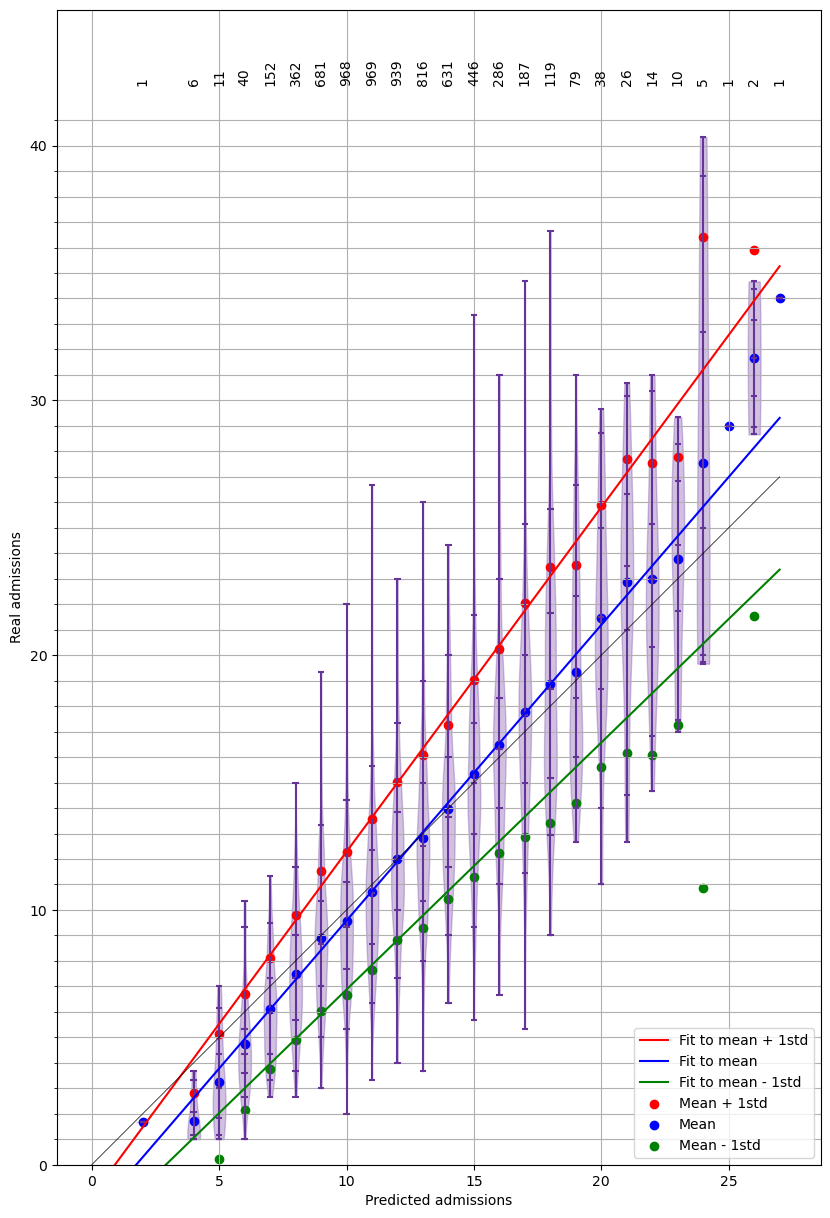

In [44]:
colour = 'RebeccaPurple'

ad_max = df_admissions_pred_from_real['admissions'].max()

fig, ax = plt.subplots(figsize=(15, 15))

for n_pred in range(ap_min, ap_max+1, 1):
    mask = df_admissions_pred_from_real['admissions_predicted_round'] == n_pred
    df_here = df_admissions_pred_from_real.filter(mask)

    if len(df_here) > 0:
        violin_bits = ax.violinplot(df_here['admissions'], positions=[n_pred], quantiles=[0.05, 0.25, 0.5, 0.75, 0.95])#showmeans=True)

        # Change colour:
        for pc in violin_bits['bodies']:
            pc.set_facecolor(colour)
            pc.set_edgecolor(colour)
        for partname in ('cbars','cmins','cmaxes', 'cquantiles'):  # 'cmeans'):
            vp = violin_bits[partname]
            vp.set_edgecolor(colour)

        # Label number of MSOA that went into violin:
        ax.annotate(len(df_here), xy=(n_pred, ad_max+2), rotation=90, va='bottom', ha='center')

# Plot mean and std lines between these x values:
x_min = 0
x_max = df_pred_ci['admissions_predicted'].max()

colour_mean = 'b'
colour_top = 'r'
colour_low = 'g'

# Mean and std lines:
ax.plot([x_min, x_max], [mean_plus_1std_c, mean_plus_1std_m*x_max + mean_plus_1std_c], label='Fit to mean + 1std', color=colour_top)
ax.plot([x_min, x_max], [mean_c, mean_m*x_max + mean_c], label='Fit to mean', color=colour_mean)
ax.plot([x_min, x_max], [mean_minus_1std_c, mean_minus_1std_m*x_max + mean_minus_1std_c], label='Fit to mean - 1std', color=colour_low)

# Original mean and std data:
ax.scatter(df_pred_ci['admissions_predicted'], df_pred_ci['mean'] + df_pred_ci['std'], label='Mean + 1std', color=colour_top)
ax.scatter(df_pred_ci['admissions_predicted'], df_pred_ci['mean'], label='Mean', color=colour_mean)
ax.scatter(df_pred_ci['admissions_predicted'], df_pred_ci['ci95_bottom'] - df_pred_ci['std'], label='Mean - 1std', color=colour_low)

ax.legend()

# ax.set_xlim(0, ad_max+5)
ax.set_ylim(0, ad_max+5)
# Equality line:
ax.plot([0, ap_max], [0, ap_max], color='k', linewidth=0.5)
ax.set_xlabel('Predicted admissions')
ax.set_ylabel('Real admissions')
ax.set_aspect('equal')

ax.set_yticks(np.arange(0, ad_max+1, 1), minor=True)
ax.grid(visible=True, which='both')

plt.show()

Apply fudge factor to the predicted admissions:

In [45]:
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns((mean_m * pl.col('admissions_predicted') + mean_c).alias('admissions_fudged_mean'))
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns((mean_plus_1std_m * pl.col('admissions_predicted') + mean_plus_1std_c).alias('admissions_fudged_meanplus1std'))
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns((mean_minus_1std_m * pl.col('admissions_predicted') + mean_minus_1std_c).alias('admissions_fudged_meanminus1std'))

# Calculate the size of the differences between mean and plus/minus values:
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns((pl.col('admissions_fudged_meanplus1std') - pl.col('admissions_fudged_mean')).alias('admissions_fudged_meanplus1std_err'))
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns((pl.col('admissions_fudged_mean') - pl.col('admissions_fudged_meanminus1std')).alias('admissions_fudged_meanminus1std_err'))

Find when the fudged admissions are within an errorbar of the real admissions:

In [46]:
mask = (
    (df_admissions_pred_from_real['admissions'] >= df_admissions_pred_from_real['admissions_fudged_meanminus1std']) &  
    (df_admissions_pred_from_real['admissions'] <= df_admissions_pred_from_real['admissions_fudged_meanplus1std'])
)


df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns(pl.lit(0).alias('real_within_err'))
df_admissions_pred_from_real = df_admissions_pred_from_real.with_columns(
    pl.when((mask))
    .then(1)         # replace with bin min
    .otherwise(pl.col('real_within_err'))  # otherwise keep the existing value
    .name.keep()
)

How many MSOA have fudged values within an errorbar of the real admission number?

In [47]:
n_within = df_admissions_pred_from_real['real_within_err'].sum()
n_total = len(df_admissions_pred_from_real)

print(n_within, n_total, 100.0*(n_within/n_total))

4703 6790 69.26362297496318


Plot points with errorbars:

40.333333332


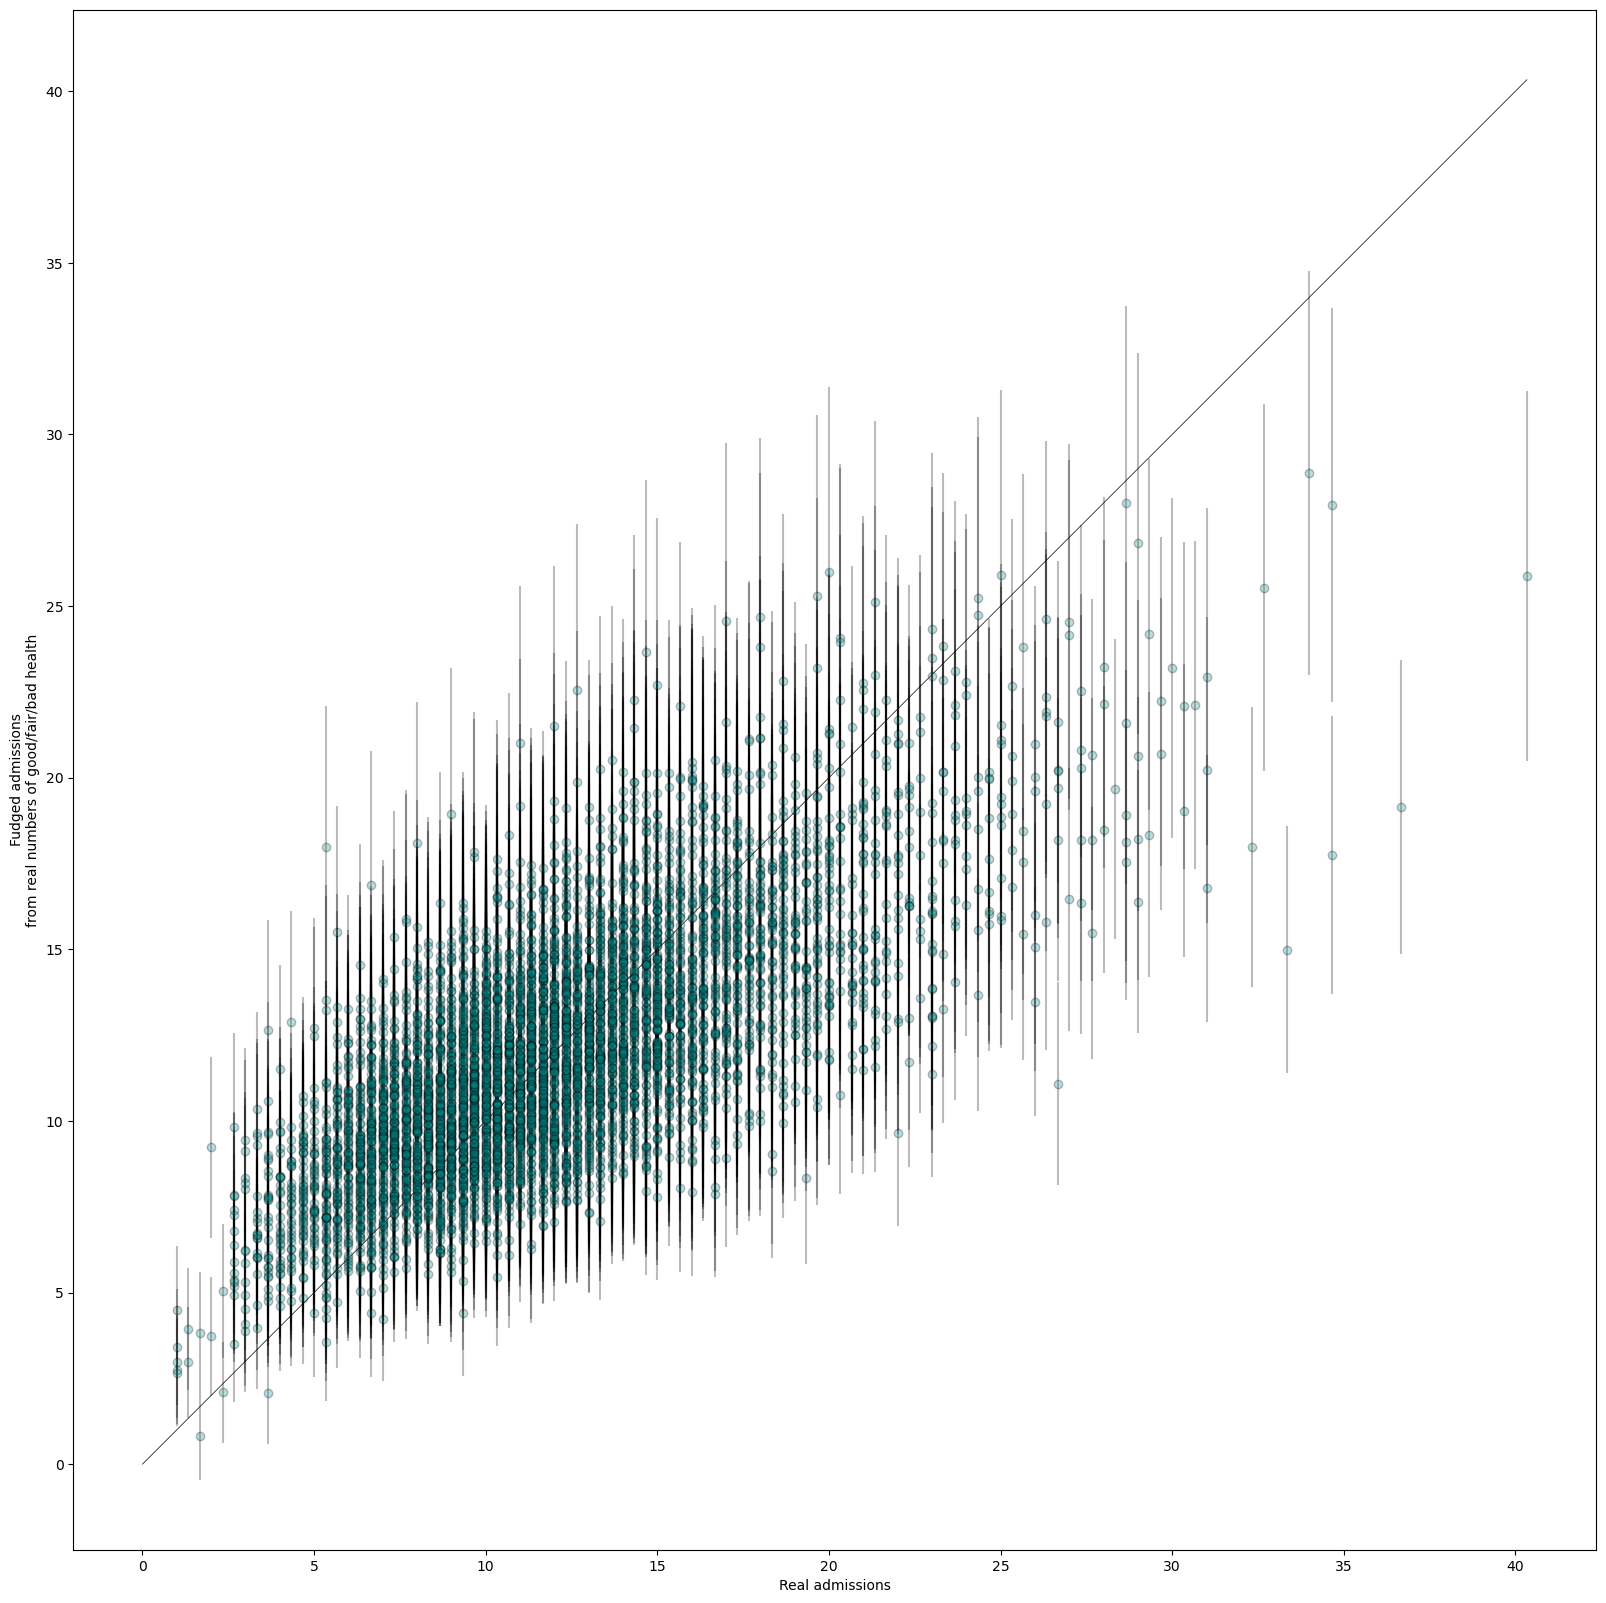

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))

# Find max across both datasets:
ad_max = df_admissions_pred_from_real[['admissions', 'admissions_fudged_mean']].max().max_horizontal().to_numpy()[0]
print(ad_max)

# Equal line:
ax.plot([0, ad_max], [0, ad_max], color='k', linewidth=0.5)
# Data:
# ax.scatter(
#     df_admissions_pred_from_real['admissions'],
#     df_admissions_pred_from_real['admissions_fudged_mean'],
#     s=2, alpha=0.2
# )
ax.errorbar(
    x=df_admissions_pred_from_real['admissions'],
    y=df_admissions_pred_from_real['admissions_fudged_mean'],
    yerr=df_admissions_pred_from_real[['admissions_fudged_meanminus1std_err', 'admissions_fudged_meanplus1std_err']].to_numpy().T,
    # s=2, alpha=0.2,
    marker='o',
    markerfacecolor='#00888844',
    color='None',
    ecolor='#00000044',
)

ax.set_xlabel('Real admissions')
ax.set_ylabel('Fudged admissions\nfrom real numbers of good/fair/bad health')
ax.set_aspect('equal')
plt.show()

For now, don't use any fudge factor for the admissions predictions.